# The spark version is 2.4.3 but if the link fails go to and see which is the spark version available


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()
file_path = "drive/My Drive/BIG DATA PROJECT/clean_data/"

In [0]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize']=(20,10)

In [0]:
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

df_accidents = sc.read.format('csv').option("header", "true").option("inferSchema", "true").load(file_path+'2010/accidents.csv')
for year in years:
  new_df = sc.read.format('csv').option("header", "true").option("inferSchema", "true").load(file_path+year+'/accidents.csv')
  df_accidents = df_accidents.union(new_df)
  
df_padro_ocupacio = sc.read.format('csv').option("header", "true").option("inferSchema", "true").option("inferSchema", "true").load(file_path+'2010/padro_ocupacio.csv')
for year in years:
  new_df = sc.read.format('csv').option("header", "true").option("inferSchema", "true").load(file_path+year+'/padro_ocupacio.csv')
  df_padro_ocupacio = df_padro_ocupacio.union(new_df)
df_padro_ocupacio.show()

+----+--------------+--------------+----------+--------------------+--------+---------+----------------------------------------+
| Any|Codi_Districte| Nom_Districte|Codi_Barri|           Nom_Barri|Població|Domicilis|Ocupació mitjana (persones per domicili)|
+----+--------------+--------------+----------+--------------------+--------+---------+----------------------------------------+
|2010|             1|  Ciutat Vella|         1|            el Raval|   48767|    17608|                                    2.77|
|2010|             1|  Ciutat Vella|         2|      el Barri Gòtic|   18720|     7128|                                    2.63|
|2010|             1|  Ciutat Vella|         3|      la Barceloneta|   16261|     7243|                                    2.25|
|2010|             1|  Ciutat Vella|         4|Sant Pere, Santa ...|   23101|    10170|                                    2.27|
|2010|             2|      Eixample|         5|       el Fort Pienc|   32900|    13046|          

In [0]:
from functools import reduce
from pyspark.sql import functions as F

sc.conf.set("spark.sql.crossJoin.enabled", "true")


df_accidents = df_accidents
df_padro_ocupacio = df_padro_ocupacio

oldColumns = df_accidents.schema.names
newColumns = ["numero_expedient", "codi_districte", "nom_districte", "codi_barri",
             "Nom_Barri", "codi_carrer", "nom_carrer", "num_postal_caption",
             "descripcio_dia_setmana", "dia_setmana", "descripcio_tipus_dia",
             "any", "numero_mes", "nom_mes", "dia_mes", "hora", "descripcio_torn",
             "descripcio_causa_vianant", "numero_morts", "lesionats_lleus",
             "lesionats_greus", "victimes", "vehicles_implicats", "coord_y", "coord_x",
             "descripcio_tipus_accident"]
df_accidents = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df_accidents)

# In this section we will analyze the probability over time of having an accident in a district of Barcelona according to the number of population living in it.

## First let's see the evolution of the inhabitants by district.

In [0]:
from pyspark.sql.functions import mean, sum, desc, countDistinct, col, round
district_name = df_padro_ocupacio.select("nom_districte").distinct().collect()
years = []

df_poblacio_and_accidents_by_years = []
for i in range(2010, 2019):
  aux_ocup = df_padro_ocupacio.filter(df_padro_ocupacio.Any == str(i)).groupBy("nom_districte").agg(sum("Població").alias("poblacio")).orderBy(desc("poblacio"))
  aux_acc = df_accidents.filter(df_accidents.any == str(i)).groupBy("nom_districte").agg(countDistinct("numero_expedient").alias("n_accidents")).orderBy(desc("n_accidents"))
  aux_combiner = aux_acc.join(aux_ocup, ["nom_districte"])
  aux_combiner = aux_combiner.withColumn('ratio', round((col('n_accidents')/col('poblacio')*100), 2))
  df_poblacio_and_accidents_by_years.append(aux_combiner)

year_poblacio = {}
year_accidents = {}
year_ratio = {}
for i in range(0, 9):
  years.append(2010+i)
  for r in df_poblacio_and_accidents_by_years[i].collect():
    if r.nom_districte in year_accidents:
      year_accidents[r.nom_districte].append(float(r.n_accidents))
      year_ratio[r.nom_districte].append(float(r.ratio))
      year_poblacio[r.nom_districte].append(float(r.poblacio))
    else:
      year_accidents[r.nom_districte] = [float(r.n_accidents)]  
      year_ratio[r.nom_districte] = [float(r.ratio)] 
      year_poblacio[r.nom_districte] = [float(r.poblacio)] 


+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|      District|    2010|    2011|    2012|    2013|    2014|    2015|    2016|    2017|    2018|
+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|      Eixample|267534.0|264996.0|265592.0|264851.0|265303.0|263991.0|264487.0|267184.0|266754.0|
|Sants-Montjuïc|184270.0|182764.0|183614.0|182353.0|182234.0|181307.0|181162.0|182354.0|182184.0|
|Horta-Guinardó|170944.0|169501.0|168515.0|167940.0|167235.0|167318.0|167571.0|169187.0|170249.0|
|     Les Corts| 83211.0| 82340.0| 82238.0| 81570.0| 81610.0| 81694.0| 81708.0| 82201.0| 82182.0|
|   Sant Andreu|147349.0|146948.0|146952.0|146539.0|146969.0|147307.0|146706.0|147693.0|148560.0|
|  Ciutat Vella|106849.0|104048.0|105216.0|104334.0|102237.0|100227.0|100451.0|102250.0|102138.0|
|    Nou Barris|169016.0|167535.0|167161.0|165737.0|165718.0|165404.0|164971.0|166805.0|168327.0|
+--------------+----

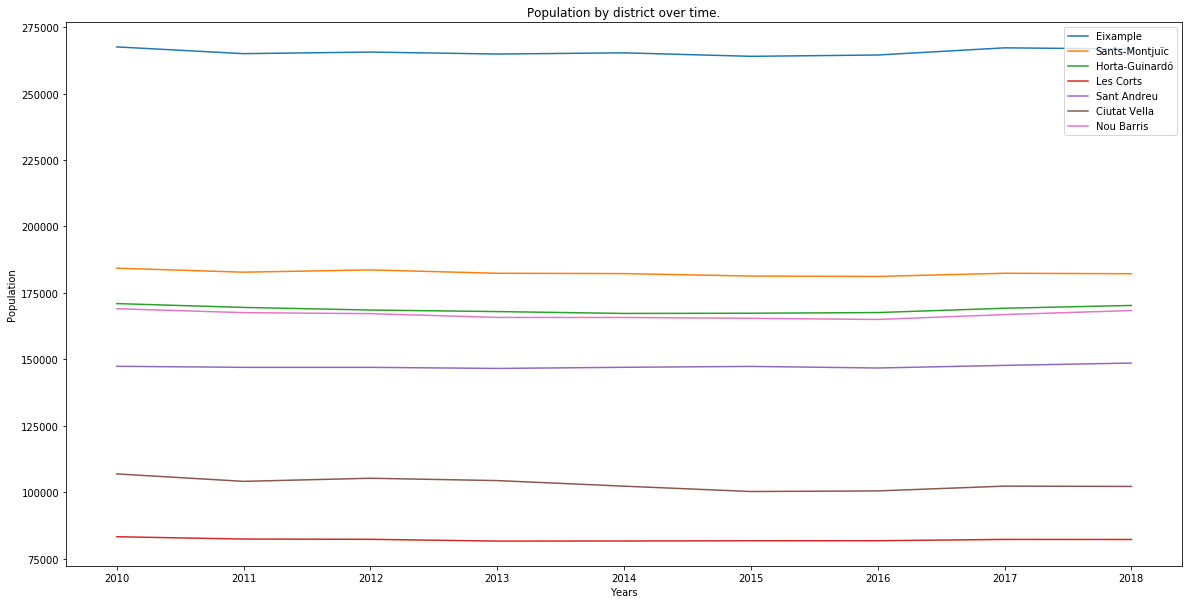

In [0]:
from pyspark.sql import Row
from pyspark.sql.types import *
data_f = []
schema = StructType([
        StructField("District", StringType(), True),
        StructField("2010", DoubleType(), True),
        StructField("2011", DoubleType(), True),
        StructField("2012", DoubleType(), True),
        StructField("2013", DoubleType(), True),
        StructField("2014", DoubleType(), True),
        StructField("2015", DoubleType(), True),
        StructField("2016", DoubleType(), True),
        StructField("2017", DoubleType(), True),
        StructField("2018", DoubleType(), True)
])


for key in year_poblacio:
  data_f.append(Row(key, year_poblacio[key][0], year_poblacio[key][1],year_poblacio[key][2],year_poblacio[key][3],year_poblacio[key][4],
     year_poblacio[key][5], year_poblacio[key][6], year_poblacio[key][7], year_poblacio[key][8]))
sc.createDataFrame(data_f, schema=schema).show()

for key in year_poblacio:
  plt.plot(years, year_poblacio[key], label=key)
plt.title("Population by district over time.")
plt.xlabel("Years")
plt.ylabel("Population")
plt.legend()
plt.show()

## Second, let's see their accidents over time.

+--------------+------+------+------+------+------+------+------+------+------+
|      District|  2010|  2011|  2012|  2013|  2014|  2015|  2016|  2017|  2018|
+--------------+------+------+------+------+------+------+------+------+------+
|      Eixample|2498.0|2433.0|2636.0|2757.0|2907.0|3029.0|3118.0|3028.0|2946.0|
|Sants-Montjuïc| 971.0| 904.0|1006.0|1047.0|1040.0|1041.0|1106.0|1103.0|1032.0|
|Horta-Guinardó| 752.0| 669.0| 609.0| 634.0| 630.0| 734.0| 727.0| 743.0| 724.0|
|     Les Corts| 653.0| 624.0| 621.0| 692.0| 671.0| 695.0| 739.0| 726.0| 671.0|
|   Sant Andreu| 556.0| 551.0| 587.0| 622.0| 602.0| 637.0| 560.0| 597.0| 676.0|
|  Ciutat Vella| 487.0| 574.0| 576.0| 576.0| 528.0| 591.0| 531.0| 600.0| 561.0|
|    Nou Barris| 479.0| 433.0| 540.0| 486.0| 522.0| 506.0| 515.0| 542.0| 551.0|
+--------------+------+------+------+------+------+------+------+------+------+



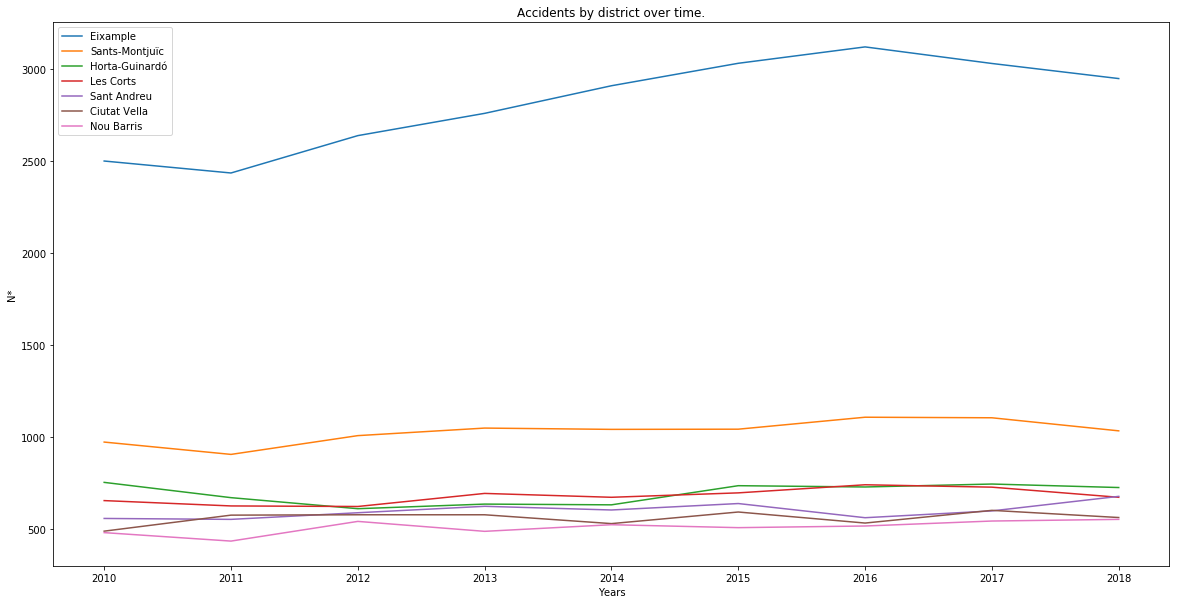

In [0]:
data_f = []
for key in year_accidents:
  data_f.append(Row(key, year_accidents[key][0], year_accidents[key][1],year_accidents[key][2],year_accidents[key][3],year_accidents[key][4],
     year_accidents[key][5], year_accidents[key][6], year_accidents[key][7], year_accidents[key][8]))
sc.createDataFrame(data_f, schema=schema).show()

for key in year_accidents:
  plt.plot(years, year_accidents[key], label=key)
plt.title("Accidents by district over time.")
plt.xlabel("Years")
plt.ylabel("N*")
plt.legend()
plt.show()

## Does the number of inhabitants of a district and their number of accidents have a direct relationship?


+--------------+----+----+----+----+----+----+----+----+----+
|      District|2010|2011|2012|2013|2014|2015|2016|2017|2018|
+--------------+----+----+----+----+----+----+----+----+----+
|      Eixample|0.93|0.92|0.99|1.04| 1.1|1.15|1.18|1.13| 1.1|
|Sants-Montjuïc|0.53|0.49|0.55|0.57|0.57|0.57|0.61| 0.6|0.57|
|Horta-Guinardó|0.44|0.39|0.36|0.38|0.38|0.44|0.43|0.44|0.43|
|     Les Corts|0.78|0.76|0.76|0.85|0.82|0.85| 0.9|0.88|0.82|
|   Sant Andreu|0.38|0.37| 0.4|0.42|0.41|0.43|0.38| 0.4|0.46|
|  Ciutat Vella|0.46|0.55|0.55|0.55|0.52|0.59|0.53|0.59|0.55|
|    Nou Barris|0.28|0.26|0.32|0.29|0.31|0.31|0.31|0.32|0.33|
+--------------+----+----+----+----+----+----+----+----+----+



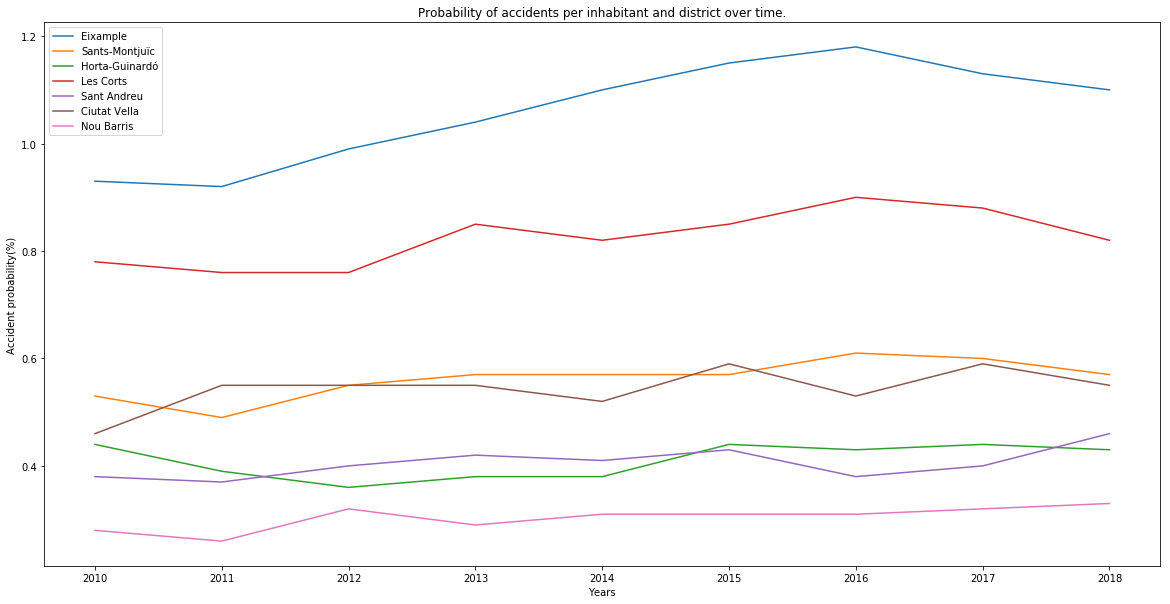

In [0]:
data_f = []
for key in year_ratio:
  data_f.append(Row(key, year_ratio[key][0], year_ratio[key][1],year_ratio[key][2],year_ratio[key][3],year_ratio[key][4],
     year_ratio[key][5], year_ratio[key][6], year_ratio[key][7], year_ratio[key][8]))
sc.createDataFrame(data_f, schema=schema).show()

for key in year_ratio:
  plt.plot(years, year_ratio[key], label=key)
plt.title("Probability of accidents per inhabitant and district over time.")
plt.xlabel("Years")
plt.ylabel("Accident probability(%)")
plt.legend()
plt.show()


As can be deduced after seeing the graphs, the number of inhabitants of the district is closely related to the number of accidents of the same. Even so, we can see that this does not have a linear relationship, since the increase or reduction of inhabitants does not have the same effect in all the districts, giving the understanding that there are other variables that influence them. Even so, it is clear in the increases of the population in a zone supposes an increase of accidents of the same one.
